<a href="https://colab.research.google.com/github/cgrundman/nuclear-magnetic-resonance/blob/master/pattern_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Recognizer

This is the last stage of the Continuous Wave Nuclear Magnatic Resonance Project found at: https://github.com/cgrundman/nuclear-magnetic-resonance. Found in this documentation is merely the information crucial to creating and evaluating the ML model. For more details, please refer to the ``readme`` in the above link.

## Import Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
from tabulate import tabulate
import datetime
import numpy as np
import pandas as pd
from google.colab import userdata, files
import os

## Load Data

In [2]:
# Connect to Kaggle
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# Load dataset from Kaggle
!kaggle datasets download -d christiangrundman/simulated-nmr-data
!unzip -q "simulated-nmr-data.zip"

Dataset URL: https://www.kaggle.com/datasets/christiangrundman/simulated-nmr-data
License(s): MIT
 93% 119M/128M [00:01<00:00, 118MB/s]
100% 128M/128M [00:01<00:00, 91.7MB/s]


## Visualize Data

Text(0.5, 1.08, 'Material Samples')

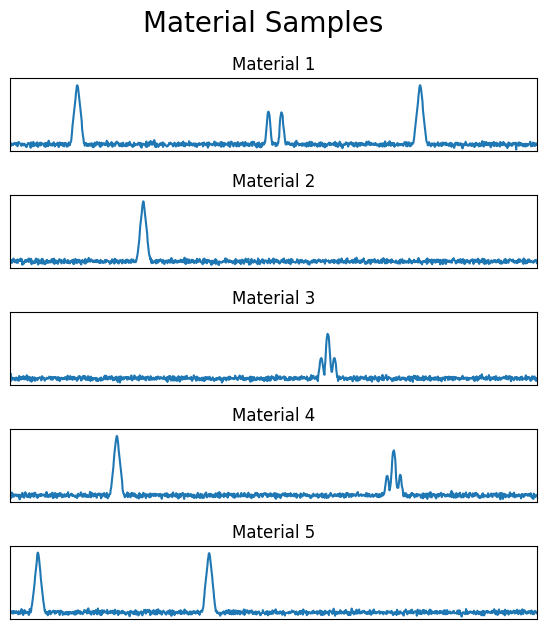

In [3]:
# Dataset Directory
data_dir = "/content/processed_nmr_data/"

# Plot data examples
# plt.style.use('dark_background')
fig, axs = plt.subplots(5, 1, figsize=(6, 6))
fig.tight_layout()

for i, row in enumerate(axs):
    file = f"0000_Material_{i+1}.txt"
    freq = np.linspace(16, 20, num=1200)
    load_data = np.loadtxt(data_dir + file)
    row.title.set_text(f"Material {i+1}")
    row.plot(freq, load_data)
    row.set_xticks([])
    row.set_yticks([])
    row.set_xlim([16, 20])
    row.set_ylim([.25, 3])
plt.suptitle("Material Samples", fontsize=20, y='1.08')

## Process Data

In [4]:
# Merge data set into a single list
data = []
mat_labels = []
directory = '/content/processed_nmr_data'

import glob

filelist = glob.glob(os.path.join(directory, '*.txt'))
for file in sorted(filelist):
  mat_labels.append(int(file[-5:-4]))

  text_file = open(file, "r")
  lines = text_file.read().split('\n')
  data.append(lines)
  text_file.close()

# Display data sizes
print(f"Number of samples: {len(data)}")
print(f"Number of features: {len(data[0])}")

Number of samples: 10000
Number of features: 1201


In [5]:
# Convert list to numpy array
X = np.array(data)
y = np.array(mat_labels)

# Remove dead column in data
X = np.delete(X, 1200, axis=1)

# Move labels to 0-4 rather than 1-5
y -= 1

# Covert NMR data to float32 and round to 4 decimal places
X = np.round(X.astype(np.float32), decimals=4)

### Train/Test/Validate Split

It is normally good practice to shuffle the data into its subsets. The data is generated using a random values. Therefore, this data can be split in order, to preserve te the number of each material within the test/train/validate splits.

In [6]:
# Create the split ratios and calculate the indexes
train_ratio = 0.8
test_ratio = round((1 - train_ratio)/2, 1) # Problems in number storage, must round
train_index = int(len(y) * train_ratio)
test_index = int(len(y) * test_ratio) + train_index

# Split the data into training, test, and validation sets
X_train, X_test, X_val = X[:train_index], X[train_index:test_index], X[test_index:]
y_train, y_test, y_val = y[:train_index], y[train_index:test_index], y[test_index:]

print(f"Train data:      {len(y_train)}")
print(f"Test data:       {len(y_test)}")
print(f"Validation data: {len(y_val)}")

Train data:      8000
Test data:       1000
Validation data: 1000


### Convert to Datasets

In [7]:
# Create Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Shuffle and batch the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

## Deep Learning Models

3 different neural network models will be evaulated for this task:
1. Neural Network
2. Recurent Neural Network
3. Long Short-Term Memory (on hold)

Each model has a different architecture, so it will be seen how the different models learn from the data.

In [8]:
# Import libraries
from keras.models import Sequential
from keras.layers import InputLayer, Dense, SimpleRNN, LSTM, Dropout
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

### Model 1 - Deep Neural Network (NN)

In [9]:
# Set the random seed
tf.random.set_seed(42)

model_nn = []

# Create the model
model_nn = Sequential([
    InputLayer((1200)),
    Dense(8, activation="relu"),
    Dense(8, activation="relu"),
    Dense(5, activation="softmax"),
])

# 2. Compile the model
model_nn.compile(loss=SparseCategoricalCrossentropy(),
                 optimizer=Adam(),
                 metrics=["accuracy"])

# Fit the model
history_nn = model_nn.fit(train_dataset,
                          epochs=10,
                          validation_data=val_dataset)

Epoch 1/10
250/250 [==============================] - 1s 3ms/step - loss: 0.8374 - accuracy: 0.7623 - val_loss: 0.3391 - val_accuracy: 1.0000
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 0.2030 - accuracy: 1.0000 - val_loss: 0.1099 - val_accuracy: 1.0000
Epoch 3/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0534 - accuracy: 1.0000 - val_loss: 0.0175 - val_accuracy: 1.0000
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 5/10
250/250 [==============================] - 1s 3ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 6/10
250/250 [==============================] - 1s 2ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 7/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 

In [10]:
# Get a model summary
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 9608      
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 5)                 45        
                                                                 
Total params: 9725 (37.99 KB)
Trainable params: 9725 (37.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Evaluate the model
model_nn.evaluate(test_dataset)

32/32 [==============================] - 0s 2ms/step - loss: 4.7107e-04 - accuracy: 1.0000


[0.00047106831334531307, 1.0]

In [12]:
# Save and download model
today = datetime.datetime.today().strftime('%Y-%m-%d')
model_nn_file = f"model_nn_{today}.keras"
model_nn.save(model_nn_file)
files.download(model_nn_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model 2 - Recurent Neural Network (RNN)

In [31]:
# Create the model
model_rnn = Sequential([
    SimpleRNN(
        units=8,
        # activation="tanh",
        return_sequences=True,
        input_shape=(1200, 1)
    ),
    SimpleRNN(units=4),
    Dense(5, activation="softmax")
])

# Compile the model
model_rnn.compile(loss=SparseCategoricalCrossentropy(),
                  optimizer=Adam(),
                  metrics=["accuracy"])

# Fit the model
history_rnn = model_rnn.fit(train_dataset,
                            epochs=10,
                            validation_data=val_dataset)

Epoch 1/10
250/250 [==============================] - 136s 533ms/step - loss: 1.6192 - accuracy: 0.1943 - val_loss: 1.6111 - val_accuracy: 0.2020
Epoch 2/10
250/250 [==============================] - 130s 520ms/step - loss: 1.6105 - accuracy: 0.2036 - val_loss: 1.6104 - val_accuracy: 0.2140
Epoch 3/10
250/250 [==============================] - 129s 516ms/step - loss: 1.6101 - accuracy: 0.1992 - val_loss: 1.6101 - val_accuracy: 0.1930
Epoch 4/10
250/250 [==============================] - 128s 509ms/step - loss: 1.6099 - accuracy: 0.1995 - val_loss: 1.6105 - val_accuracy: 0.1920
Epoch 5/10
250/250 [==============================] - 125s 499ms/step - loss: 1.6099 - accuracy: 0.2040 - val_loss: 1.6102 - val_accuracy: 0.2070
Epoch 6/10
250/250 [==============================] - 130s 519ms/step - loss: 1.6096 - accuracy: 0.2021 - val_loss: 1.6101 - val_accuracy: 0.2040
Epoch 7/10
250/250 [==============================] - 126s 504ms/step - loss: 1.6097 - accuracy: 0.2009 - val_loss: 1.6101 -

In [32]:
# Get a model summary
model_rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 1200, 8)           80        
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 4)                 52        
                                                                 
 dense_7 (Dense)             (None, 5)                 25        
                                                                 
Total params: 157 (628.00 Byte)
Trainable params: 157 (628.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# Evaluate the model
model_rnn.evaluate(test_dataset)

32/32 [==============================] - 2s 78ms/step - loss: 1.2828 - accuracy: 0.4110


[1.2827775478363037, 0.41100001335144043]

In [34]:
# Save and download model
model_rnn_file = f"model_rnn_{today}.keras"
model_rnn.save(model_rnn_file)
files.download(model_rnn_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model 3 - Long Short-Term Memory (LSTM)

(on hold)

In [18]:
# # Create the model
# model_lstm = Sequential([
#     LSTM(units=50, activation="tanh", return_sequences=True, input_shape=(1200, 1)),
#     Dropout(0.2),
#     LSTM(units=50, activation="tanh", return_sequences=True),
#     Dropout(0.2),
#     LSTM(units=50, activation="tanh", return_sequences=True),
#     Dropout(0.2),
#     LSTM(units=50),
#     Dropout(0.2),
#     Dense(5, activation="softmax")
# ])

# # Compile the model
# model_lstm.compile(loss=SparseCategoricalCrossentropy(),
#                    optimizer=Adam(),
#                    metrics=["accuracy"])

# # Fit the model
# history_lstm = model_lstm.fit(train_dataset,
#                               epochs=10,
#                               validation_data=val_dataset)

In [19]:
# # Get a model summary
# model_lstm.summary()

In [20]:
# # Evaluate the model
# model_lstm.evaluate(test_dataset)

In [21]:
# # Save and download model
# model_lstm_file = f"model_lstm_{today}.keras"
# model_lstm.save(model_lstm_file)
# files.download(model_lstm_file)

## Compare Model Performance

In [22]:
!git clone https://github.com/cgrundman/matplotlib-custom-plots.git

import sys
sys.path.append('/content/matplotlib-custom-plots')

# here is your import
from custom_plots import CustomPlot

Cloning into 'matplotlib-custom-plots'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 29 (delta 4), reused 22 (delta 3), pack-reused 0
Receiving objects: 100% (29/29), 152.92 KiB | 3.32 MiB/s, done.
Resolving deltas: 100% (4/4), done.


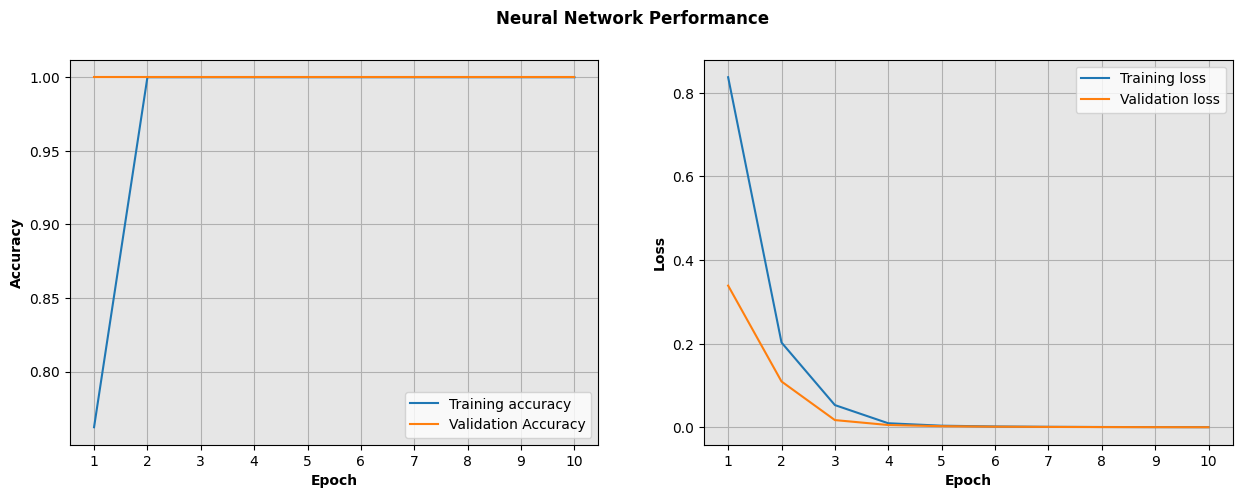

In [23]:
CustomPlot.plot_model_performance_accuracy(history=history_nn.history,
                                model_name="Neural Network")

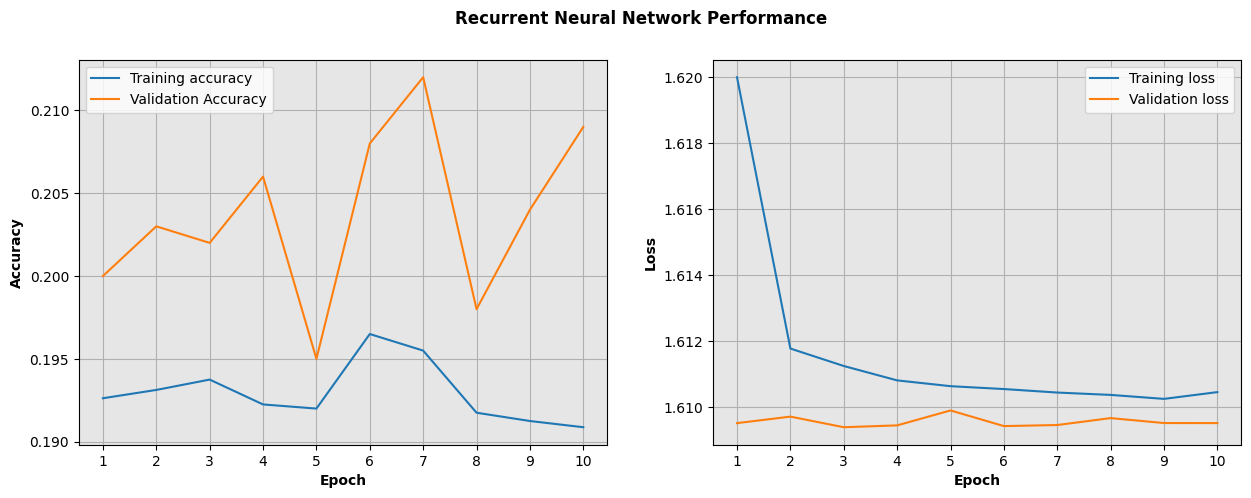

In [24]:
CustomPlot.plot_model_performance_accuracy(history=history_rnn.history,
                                model_name="Recurrent Neural Network")

In [25]:
history_rnn.history
history_nn.history

{'loss': [0.8373820781707764,
  0.20302607119083405,
  0.05341171845793724,
  0.009940877556800842,
  0.004107920452952385,
  0.002296948339790106,
  0.001463002641685307,
  0.0010036645689979196,
  0.0007237790268845856,
  0.0005411967285908759],
 'accuracy': [0.7622500061988831, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_loss': [0.33911430835723877,
  0.10985688120126724,
  0.01753445714712143,
  0.005742703564465046,
  0.002937441458925605,
  0.0017864301335066557,
  0.0011894275667145848,
  0.0008407767745666206,
  0.0006208003032952547,
  0.0004701752623077482],
 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

Exception ignored in: <function _xla_gc_callback at 0x7c57d0e845e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


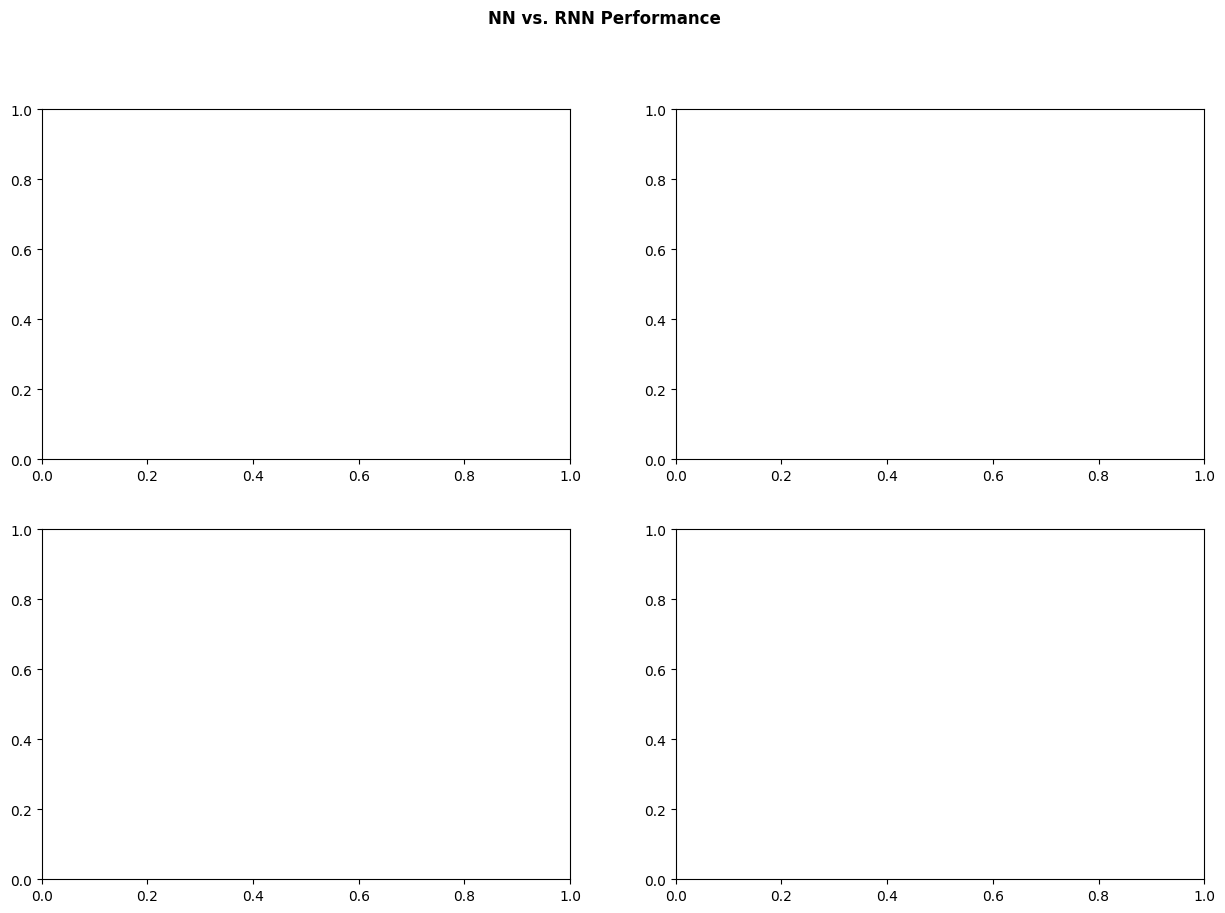

In [36]:
def compare_model_performance_accuracy(history_list, model_name_list=["[Model 1]", "[Model 2]"]):

  f, axs = plt.subplots(2,2)

  # Set figure size
  f.set_figheight(10)
  f.set_figwidth(15)

  # # Set plot overall title
  # Create the title
  title = ""
  for i in range(len(model_name_list)):
    if title == "":
      title = model_name_list[i]
    else:
      title += " vs. " + model_name_list[i]
  title += " Performance"
  f.suptitle(title, weight='bold')

  # epoch_range = range(1,len(history['accuracy']) + 1)
  list_of_metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']

  # axs = np.flatten(axs)

  # for i in range(len(list_of_metrics)):
  #   axs[0,0].set_xlabel('Epoch', weight='bold')
  #   axs[1,0].set_facecolor((0.9, 0.9, 0.9))
  #   axs[0,1].grid()

  # # Plot Training Accuracy
  # ax[0].plot(epoch_range, history['accuracy'])
  # ax[0].plot(epoch_range, history['val_accuracy'])
  # ax[0].legend(['Training accuracy', 'Validation Accuracy'])
  # ax[0].set_ylabel('Accuracy', weight='bold')
  # ax[0].set_xlabel('Epoch', weight='bold')
  # ax[0].set_xticks(x_axis_range)
  # ax[0].set_facecolor((0.9, 0.9, 0.9))
  # ax[0].grid()

  # # Plot Training Loss
  # ax[1].plot(epoch_range, history['loss'])
  # ax[1].plot(epoch_range, history['val_loss'])
  # ax[1].legend(['Training loss', 'Validation loss'])
  # ax[1].set_ylabel('Loss', weight='bold')
  # ax[1].set_xlabel('Epoch', weight='bold')
  # ax[1].set_xticks(x_axis_range)
  # ax[1].set_facecolor((0.9, 0.9, 0.9))
  # ax[1].grid()

  # plt.savefig(f'{model_name}.png')




history_test_list = [history_rnn.history, history_nn.history]
model_name_list = ["NN", "RNN"]

compare_model_performance_accuracy(history_list=history_test_list,
                                   model_name_list=model_name_list)


## Conclusion

In [37]:
# TODO conclude results of experiment